# <center>UrbanSound8K - Data Augmentation</center>

## Libraries Import

In [11]:
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import IPython
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchaudio
import torchaudio.transforms as transforms
from torch_audiomentations import Compose, Gain, PitchShift, Shift

## Paths

In [3]:
dataset_path = "../dataset"
figures_path = "../figures"

## Dataset Class

In [167]:
# Dataset class adapted for this particular notebook
class UrbanSound8KDataset(Dataset):
    
    def __init__(self, dataset_path, feature_name, preprocessing_parameters, signal_augmentation=False, feature_augmentation=False):
        self.dataset_path = dataset_path
        self.metadata = pd.read_csv(os.path.join(dataset_path, "UrbanSound8K.csv"))
        self.feature_name = feature_name
        self.parameters = preprocessing_parameters
        self.signal_augmentation = signal_augmentation
        self.feature_augmentation = feature_augmentation
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, index):
        audio_name = self._get_event_audio_name(index)
        class_id = torch.tensor(self._get_event_class_id(index), dtype=torch.long)
        class_name = self._get_event_class_name(index)
        signal, sr = self._get_event_signal(index)
        signal = self._mix_down_if_necessary(signal)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        original_signal = signal.clone()
        if self.signal_augmentation:
            signal = self._signal_augmentation(signal)
        if self.feature_name == "spectrogram":
            feature = self._spectrogram_transform(signal)
            original_feature = feature.clone()
            if self.feature_augmentation:
                feature = self._feature_augmentation(feature)
            original_feature = self._db_transform(original_feature)
            feature = self._db_transform(feature)
        elif self.feature_name == "mel-spectrogram":
            feature = self._mel_spectrogram_transform(signal)
            original_feature = feature.clone()
            if self.feature_augmentation:
                feature = self._feature_augmentation(feature)
            original_feature = self._db_transform(original_feature)
            feature = self._db_transform(feature)
        elif self.feature_name == "mfcc":
            feature = self._mfcc_transform(signal)
            original_feature = feature.clone()
            if self.feature_augmentation:
                feature = self._feature_augmentation(feature)            
        return index, class_id, original_signal, signal, original_feature, feature
    
    def _get_event_class_id(self, index):
        return self.metadata.iloc[index]["classID"]
    
    def _get_event_class_name(self, index):
        return self.metadata.iloc[index]["class"]
    
    def _get_event_audio_name(self, index):
        return self.metadata.iloc[index]["slice_file_name"]
    
    def _get_event_signal(self, index):
        event_fold = f"fold{self.metadata.iloc[index]['fold']}"
        event_filename = self.metadata.iloc[index]["slice_file_name"]
        audio_path = os.path.join(self.dataset_path, event_fold, event_filename)
        signal, sr = torchaudio.load(audio_path, normalize=True)
        return signal, sr
    
    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
        
    def _resample_if_necessary(self, signal, sr):
        if sr != self.parameters["target_sample_rate"]:
            resample_transform = transforms.Resample(sr, self.parameters["target_sample_rate"])
            signal = resample_transform(signal)
        return signal
    
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.parameters["n_samples"]:
            signal = signal[:, :self.parameters["n_samples"]]
        return signal
        
    def _right_pad_if_necessary(self, signal):
        signal_length = signal.shape[1]
        if signal_length < self.parameters["n_samples"]:
            num_missing_samples = self.parameters["n_samples"] - signal_length
            last_dim_padding = (0, num_missing_samples)
            signal = nn.functional.pad(signal, last_dim_padding)
        return signal
    
    def _signal_augmentation(self, signal):
        signal = signal.unsqueeze(0)
        signal_transforms = Compose([
                                    Gain(min_gain_in_db=-15.0, max_gain_in_db=50.0, p=1.0),
                                    PitchShift(min_transpose_semitones=3, max_transpose_semitones=4, p=1.0, sample_rate=self.parameters["target_sample_rate"], target_rate=self.parameters["target_sample_rate"]),
                                    Shift(min_shift=-0.5, max_shift=0.5, p=1.0, sample_rate=self.parameters["target_sample_rate"], target_rate=self.parameters["target_sample_rate"])
                                    ], p=1.0, shuffle=False)
        signal = signal_transforms(samples=signal, sample_rate=self.parameters["target_sample_rate"])
        signal = signal.squeeze(0)
        return signal
    
    def _spectrogram_transform(self, signal):
        spectrogram_transform = transforms.Spectrogram(
                                                        n_fft = self.parameters["n_fft"],
                                                        win_length = self.parameters["n_fft"],
                                                        hop_length = self.parameters["n_fft"] // self.parameters["hop_denominator"],
                                                        pad = 0,
                                                        window_fn = torch.hann_window,
                                                        power = 2,
                                                        normalized = True,
                                                        wkwargs = None,
                                                        center = False,
                                                        pad_mode = "reflect",
                                                        onesided = True,
                                                        return_complex = False
                                                        )  
        spectrogram = spectrogram_transform(signal)
        return spectrogram
    
    def _mel_spectrogram_transform(self, signal):
        mel_spectrogram_transform = transforms.MelSpectrogram(
                                                        sample_rate = self.parameters["target_sample_rate"],
                                                        n_fft = self.parameters["n_fft"],
                                                        n_mels = self.parameters["n_mels"],
                                                        window_fn = torch.hann_window,
                                                        power = 2,
                                                        normalized = True,
                                                        wkwargs = None,
                                                        center = True,
                                                        pad_mode = "reflect",
                                                        onesided = True,
                                                        norm = None,
                                                        mel_scale = "htk"
                                                        )
        mel_spectrogram = mel_spectrogram_transform(signal)
        return mel_spectrogram

    def _mfcc_transform(self, signal):
        mfcc_transform = transforms.MFCC(
                                        sample_rate = self.parameters["target_sample_rate"],
                                        n_mfcc = self.parameters["n_mfcc"],
                                        dct_type = 2,
                                        norm = "ortho",
                                        log_mels = False 
                                        )
        mfcc = mfcc_transform(signal)
        return mfcc
    
    def _db_transform(self, spectrogram):
        db_transform = transforms.AmplitudeToDB(stype="power")
        spectrogram_db = db_transform(spectrogram)
        return spectrogram_db

    def _feature_augmentation(self, feature):
        feature_height = feature.size(dim=1)
        feature_width = feature.size(dim=2)
        freq_mask_len = math.ceil(0.1*feature_height)
        time_mask_len = math.ceil(0.1*feature_width)
        frequency_masking = transforms.FrequencyMasking(freq_mask_param=freq_mask_len)
        time_masking = transforms.TimeMasking(time_mask_param=time_mask_len, p=1.0)
        feature = frequency_masking(feature)
        feature = time_masking(feature)
        return feature

## Processing Parameters

In [168]:
# Audio pre-processing parameters
target_sample_rate = 22050
target_length = 4
n_samples = target_length * target_sample_rate

spectrogram_parameters = {
                    "target_sample_rate": target_sample_rate,
                    "target_length": target_length,
                    "n_samples": n_samples,
                    "n_fft": 512,
                    "hop_denominator": 2,
}

melspectrogram_parameters = {
                    "target_sample_rate": target_sample_rate,
                    "target_length": target_length,
                    "n_samples": n_samples,
                    "n_fft": 512,
                    "hop_denominator": 2,
                    "n_mels": 64, 
}

mfcc_parameters = {
                    "target_sample_rate": target_sample_rate,
                    "target_length": target_length,
                    "n_samples": n_samples,
                    "n_mfcc": 40      
}

## Instantiation of the Dataset

In [169]:
feature = "mel-spectrogram"

if feature == "spectrogram":
    preprocessing_parameters = spectrogram_parameters
elif feature == "mel-spectrogram":
    preprocessing_parameters = melspectrogram_parameters
elif feature == "mfcc":
    preprocessing_parameters = mfcc_parameters

In [184]:
ds = UrbanSound8KDataset(
                        dataset_path=dataset_path, 
                        feature_name=feature,
                        preprocessing_parameters=preprocessing_parameters,
                        signal_augmentation=True,
                        feature_augmentation=True
                        )

## Choice of an event

In [185]:
event = ds.metadata[
    ds.metadata["classID"] == 3
].sample(1)
event

,slice_file_name,fsID,start,end,salience,fold,classID,class
8551,95549-3-0-6.wav,95549,14.181689,18.181689,2,8,3,dog_bark


In [186]:
event_idx = event.index.item()
audio_name = event["slice_file_name"].item()
fold = event["fold"].item()
class_name = event["class"].item()

In [187]:
_, _, original_signal, transformed_signal, original_feature, transformed_feature = ds[event_idx]

## Augmentations Visualisation

### Time Signal Augmentations

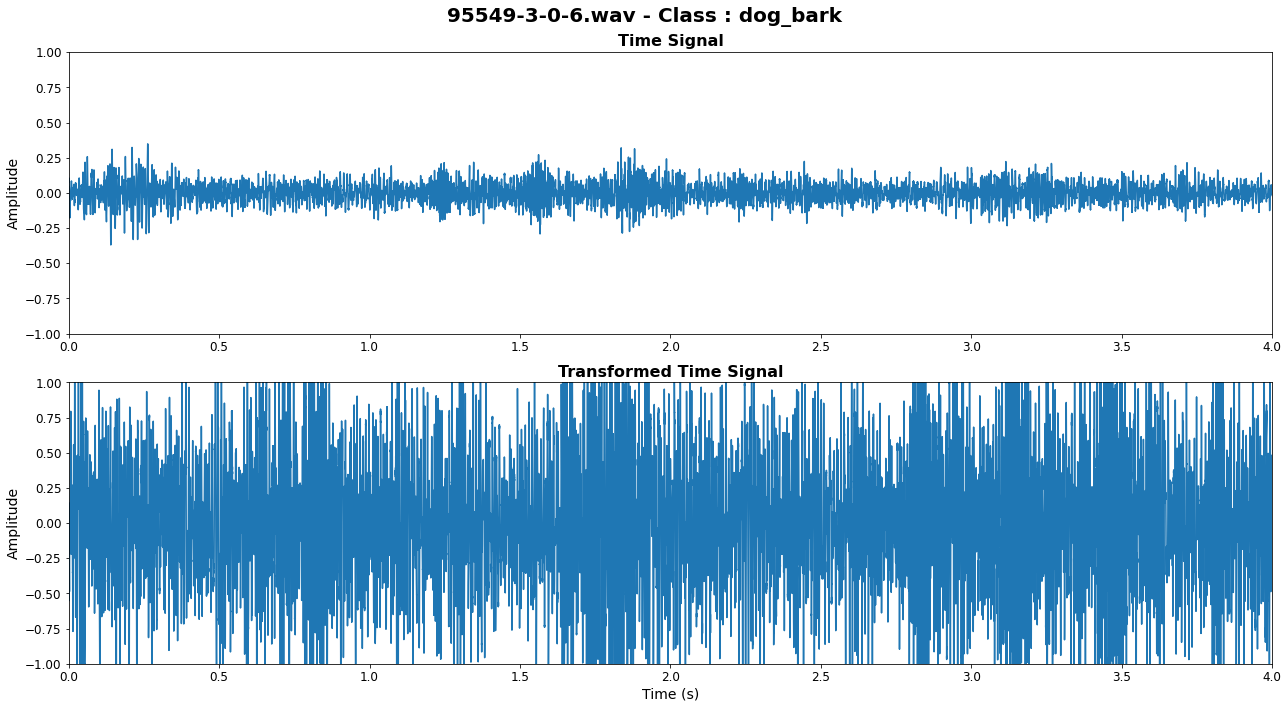

In [216]:
x = torch.arange(0, n_samples) / target_sample_rate
y_original = original_signal[0]
y_transformed = transformed_signal[0]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18,10))
ax[0].plot(x, y_original)
ax[0].set_title("Time Signal", fontsize=16, fontweight="bold")
ax[0].set_ylabel("Amplitude", fontsize=14)
ax[0].set_xlim([0, 4])    
ax[0].set_ylim([-1, 1])
ax[0].tick_params(axis="both", labelsize=12)

ax[1].plot(x, y_transformed)
ax[1].set_title("Transformed Time Signal", fontsize=16, fontweight="bold")
ax[1].set_ylabel("Amplitude", fontsize=14)
ax[1].set_xlabel("Time (s)", fontsize=14)
ax[1].set_xlim([0, 4])    
ax[1].set_ylim([-1, 1])
ax[1].tick_params(axis="both", labelsize=12)

fig.suptitle(f"{audio_name} - Class : {class_name}", fontsize=20, fontweight="bold")
plt.tight_layout()
figure_name = f"Data Augmentation - Signal Temporel - {audio_name} - {class_name}.png"
plt.savefig(os.path.join(figures_path, figure_name), bbox_inches="tight")
plt.show()

In [189]:
print("Original audio:")
display(IPython.display.Audio(filename=os.path.join(dataset_path, f"fold{fold}", audio_name)))

Original audio:


In [190]:
print("Transformed audio:")
display(IPython.display.Audio(data=y_transformed, rate=target_sample_rate))

Transformed audio:


### Feature Augmentations

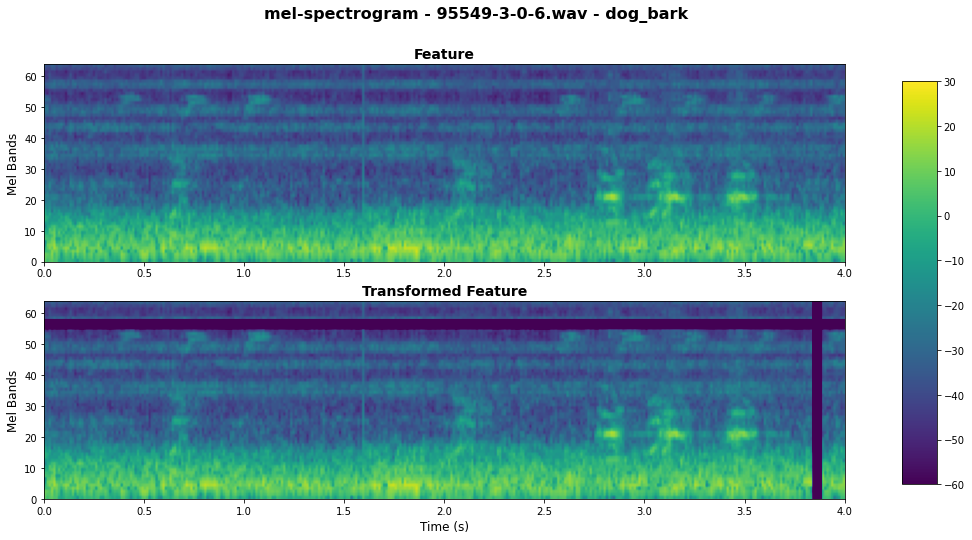

In [215]:
original_feature = torch.squeeze(original_feature)
transformed_feature = torch.squeeze(transformed_feature)
X = [original_feature, transformed_feature]  

# Colorbar range
vmin = math.floor(original_feature.min()/10)*10
vmax = math.ceil(original_feature.max()/10)*10

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,8))

for index, ax in enumerate(axes.flat):
    if feature == "spectrogram":
        im = ax.imshow(
            X[index], 
            extent=[0, target_length, 0, target_sample_rate/2], 
            origin="lower", 
            aspect="auto", 
            cmap="viridis",
            vmin=vmin, 
            vmax=vmax
        )
        ax.set_ylabel("Frequency (Hz)", fontsize=12)
    elif feature == "mel-spectrogram":
        im = ax.imshow(
            X[index], 
            extent=[0, target_length, 0, melspectrogram_parameters["n_mels"]], 
            origin="lower", 
            aspect="auto", 
            cmap="viridis", 
            vmin=vmin, 
            vmax=vmax
        ) 
        ax.set_ylabel("Mel Bands", fontsize=12)   
    elif feature == "mfcc":
        im = ax.imshow(
            X[index], 
            extent=[0, target_length, 0, mfcc_parameters["n_mfcc"]], 
            origin="lower", 
            aspect="auto", 
            cmap="viridis",
            vmin=vmin, 
            vmax=vmax
        ) 
        ax.set_ylabel("MFCC", fontsize=12)  
    
axes[0].set_title("Feature", fontsize=14, fontweight="bold")
axes[1].set_title("Transformed Feature", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Time (s)", fontsize=12)

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle(f"{feature} - {audio_name} - {class_name}", fontsize=16, fontweight="bold")

figure_name = f"Augmentation de la Représentation Spectrale - {audio_name} - {class_name}.png"
plt.savefig(os.path.join(figures_path, figure_name), bbox_inches="tight")
plt.show()